# LOO-CV on transformed data
Blog post exploring whether or not LOO-CV can be used to compare models that try to explain some data $y$ with models trying to explain the same data after a transformation $z=f(y)$. Inspired by [@tiagocc question](https://discourse.mc-stan.org/t/very-simple-loo-question/9258) on Stan Forums. Intended to be a follow up to my answer there.

In the first example, we will compare two equivalent models: 

1. $y \sim \text{LogNormal}(\mu, \sigma)$
2. $\log y \sim \text{Normal}(\mu, \sigma)$

In [1]:
import pystan
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

Define the data and execute the two models

In [2]:
mu = 2
sigma = 1
logy = np.random.normal(loc=mu, scale=sigma, size=30)
y = np.exp(logy) # y will then be distributed as lognormal
data = {
    'N': len(y),      
    'y': y,
    'logy': logy
}

In [3]:
lognormal_code = """
data {
  int<lower=0> N;
  vector[N] y;
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
    y ~ lognormal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;

    for (i in 1:N) {
        log_lik[i] = lognormal_lpdf(y[i] | mu, sigma);
        y_hat[i] = lognormal_rng(mu, sigma);
    }
}
"""

In [4]:
sm_lognormal = pystan.StanModel(model_code=lognormal_code)
fit_lognormal = sm_lognormal.sampling(data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3596002ce22937246377a0479b804226 NOW.


In [5]:
idata_lognormal = az.from_pystan(
    posterior=fit_lognormal,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood='log_lik',
)

In [6]:
normal_on_log_code = """
data {
  int<lower=0> N;
  vector[N] logy;
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
    logy ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    vector[N] logy_hat;

    for (i in 1:N) {
        log_lik[i] = normal_lpdf(logy[i] | mu, sigma);
        logy_hat[i] = normal_rng(mu, sigma);
    }
}
"""

In [7]:
sm_normal = pystan.StanModel(model_code=normal_on_log_code)
fit_normal = sm_normal.sampling(data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acd7c874588f1c862727f931f4dbf916 NOW.


In [8]:
idata_normal = az.from_pystan(
    posterior=fit_normal,
    posterior_predictive='logy_hat',
    observed_data=['logy'],
    log_likelihood='log_lik',
)

Check model convergence

In [9]:
az.summary(idata_lognormal)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.907,0.196,1.531,2.263,0.005,0.004,1366.0,1365.0,1375.0,1320.0,1.0
sigma,1.077,0.153,0.811,1.362,0.004,0.003,1497.0,1432.0,1566.0,1271.0,1.0


In [10]:
az.summary(idata_normal)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.910,0.197,1.534,2.271,0.005,0.004,1526.0,1526.0,1535.0,1099.0,1.0
sigma,1.069,0.143,0.816,1.339,0.003,0.003,1674.0,1627.0,1727.0,1333.0,1.0


Check that both models are equivalent and do indeed give the same result

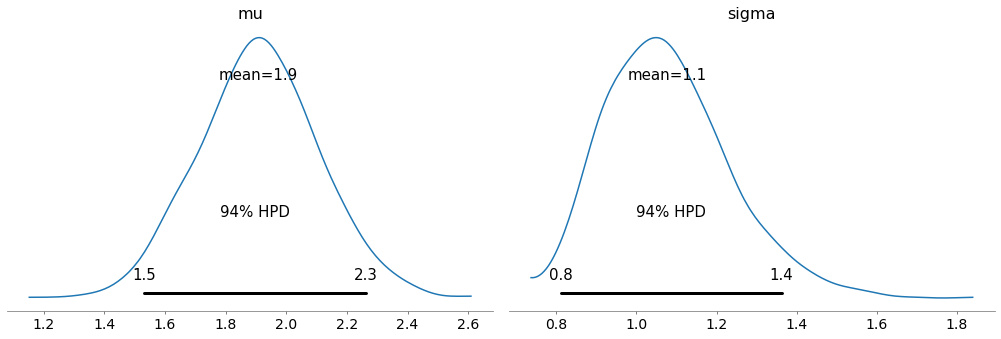

In [11]:
az.plot_posterior(idata_lognormal);

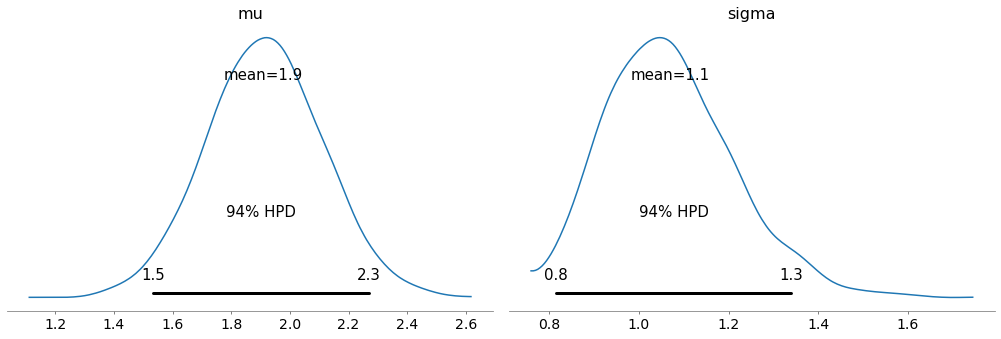

In [12]:
az.plot_posterior(idata_normal);

# Calculate LOO-CV
Now we get to calculate LOO-CV using Pareto Smoothed Importance Sampling as detailed in Vehtari et al., 2017.

In [13]:
az.loo(idata_lognormal, pointwise=True)

Computed from 2000 by 30 log-likelihood matrix

       Estimate       SE
IC_loo   203.95    12.37
p_loo      1.44        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       30  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
az.loo(idata_normal, pointwise=True)

Computed from 2000 by 30 log-likelihood matrix

       Estimate       SE
IC_loo    89.32     5.32
p_loo      1.41        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       30  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

We have found that as expected, the two models yield different results despite being actually the same model. This is because. LOO is estimated from the log likelihood, $\log p(y_i|\theta^s)$, being $i$ the observation id, and $s$ the MCMC sample id. Following Vehtari et al., 2017, this log likelihood is used to calculate the PSIS weights and to estimate the expected log pointwise predictive density in the following way:

1. Calculate raw importance weights: $r_i^s = \frac{1}{p(y_i|\theta^s)}$
2. Smooth the $r_i^s$ (see original paper for details) to get the PSIS weights $w_i^s$
3. Calculate elpd LOO as:

$$ \text{elpd}_{psis-loo} = \sum_{i=1}^n \log \left( \frac{\sum_s w_i^s p(y_i|\theta^s)}{\sum_s w_i^s} \right) $$

This will estimate the out of sample predictive fit of $y$ (where $y$ is the data of the model. Therefore, for the first model, using a LogNormal distribution, we are indeed calculating the desired quantity:

$$ \text{elpd}_{psis-loo}^{(1)} \approx \sum_{i=1}^n \log p(y_i|y_{-i}) $$

Whereas for the second model, we are calculating:

$$ \text{elpd}_{psis-loo}^{(2)} \approx \sum_{i=1}^n \log p(z_i|z_{-i}) $$

being $z_i = \log y_i$. We actually have two different probability density functions, one over $y$ which from here on we will note $p_y(y)$, and $p_z(z)$.

In order to estimate the elpd loo for $y$ from the data in the second model, $z$, we have to describe $p_y(y)$ as a function of $z$ and $p_z(z)$. We know that $y$ and $z$ are actually related, and we can use this relation to find how would the random variable $y$ which is actually a transformation of the random variable $z$ be distributed. Therefore:

$$
p_y(y|\theta)=p_z(z|\theta)|\frac{dz}{dy}|=\frac{1}{|y|}p_z(z|\theta)=e^{-z}p_z(z|\theta)
$$

In the log scale:

$$
\log p_y(y|\theta)=-z + \log p_z(z|\theta)
$$

We apply the results to the log likelihood data of the second model (the normal on the logarithm instead of the lognormal) and check that now the result does coincide with the LOO-CV estimated by the lognormal model.

In [15]:
old_like = idata_normal.sample_stats.log_likelihood
z = logy
idata_normal.sample_stats["log_likelihood"] = -z+old_like

In [16]:
az.loo(idata_normal)

Computed from 2000 by 30 log-likelihood matrix

       Estimate       SE
IC_loo   203.80    12.32
p_loo      1.41        -

## References
Vehtari, A., Gelman, A., and Gabry, J. (2017):  Practical Bayesian Model Evaluation Using Leave-One-OutCross-Validation and WAIC, _Statistics and Computing_, vol. 27(5), pp. 1413–1432.